In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

Configuración

In [ ]:
# --- 1. Configuration ---
EMBEDDING_DIM = 300      
NUM_MOLECULES = 133244   
OUTPUT_DIM = 1           # Predicting a single value ('gap')

# Hyperparameters
HIDDEN_DIM1 = 256      
HIDDEN_DIM2 = 128        
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50
TEST_SPLIT_RATIO = 0.2
RANDOM_SEED = 42         

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Cargar datos

In [ ]:
# mol2vec output
df = pd.read_csv('..\out.csv')
# Eliminar primeras 3 entradas
df = df.drop(df.index[0:3])
df = df.reset_index(drop=True)
df['Unnamed: 0'] = df['Unnamed: 0'] - 3

X = df.iloc[:, 3:]

properties = pd.read_csv('..\gdb9.sdf.csv')

property_dict = {}
for i in range(len(properties)):
    property_dict[properties['mol_id'][i]] = properties.iloc[i, 1:]

print(property_dict.keys)

y = []
for id in df['ID']:
    print(id)
    y.append(property_dict[id]['gap'])

y = np.asarray(y)

y = y.reshape(-1, 1)

# --- Data Splitting ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_SEED
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# --- Data Scaling (Optional but Recommended for Regression) ---
# Scale input features (embeddings)
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test) # Use the same scaler fitted on train data

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device) # Keep original scale for MAE/RMSE calc

# --- Create DataLoader for batching ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

<built-in method keys of dict object at 0x0000028B9F49D840>
gdb_4
gdb_5
gdb_6
gdb_7
gdb_8
gdb_9
gdb_10
gdb_11
gdb_12
gdb_13
gdb_14
gdb_15
gdb_16
gdb_17
gdb_18
gdb_19
gdb_20
gdb_21
gdb_22
gdb_23
gdb_24
gdb_25
gdb_26
gdb_27
gdb_28
gdb_29
gdb_30
gdb_31
gdb_32
gdb_33
gdb_34
gdb_35
gdb_36
gdb_37
gdb_38
gdb_39
gdb_40
gdb_41
gdb_42
gdb_43
gdb_44
gdb_45
gdb_46
gdb_47
gdb_48
gdb_49
gdb_50
gdb_51
gdb_52
gdb_53
gdb_54
gdb_55
gdb_56
gdb_57
gdb_58
gdb_59
gdb_60
gdb_61
gdb_62
gdb_63
gdb_64
gdb_65
gdb_66
gdb_67
gdb_68
gdb_69
gdb_70
gdb_71
gdb_72
gdb_73
gdb_74
gdb_75
gdb_76
gdb_77
gdb_78
gdb_79
gdb_80
gdb_81
gdb_82
gdb_83
gdb_84
gdb_85
gdb_86
gdb_87
gdb_88
gdb_89
gdb_90
gdb_91
gdb_92
gdb_93
gdb_94
gdb_95
gdb_96
gdb_97
gdb_98
gdb_99
gdb_100
gdb_101
gdb_102
gdb_103
gdb_104
gdb_105
gdb_106
gdb_107
gdb_108
gdb_109
gdb_110
gdb_111
gdb_112
gdb_113
gdb_114
gdb_115
gdb_116
gdb_117
gdb_118
gdb_119
gdb_120
gdb_121
gdb_122
gdb_123
gdb_124
gdb_125
gdb_126
gdb_127
gdb_128
gdb_129
gdb_130
gdb_131
gdb_132
gdb_133
gd

Definir Red

In [ ]:
# --- 3. Define the Neural Network Model ---
class GapPredictorMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(GapPredictorMLP, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        # Output layer
        self.layer_3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu1(x)
        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.layer_3(x) # Linear output
        return x

# Instantiate the model
model = GapPredictorMLP(EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM).to(device)
print("\nModel Architecture:")
print(model)


Model Architecture:
GapPredictorMLP(
  (layer_1): Linear(in_features=300, out_features=256, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
)


Función de pérdida

In [ ]:
# --- 4. Define Loss Function and Optimizer ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Entrenar

In [ ]:
# --- 5. Training Loop ---
print("\nStarting Training...")
train_losses = []
for epoch in range(EPOCHS):
    model.train() 
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights

        epoch_loss += loss.item() * batch_X.size(0) # Accumulate loss scaled by batch size

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_epoch_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_epoch_loss:.6f}')

print("Training Finished.")


Starting Training...
Epoch [1/50], Loss: 0.112608
Epoch [10/50], Loss: 0.049188
Epoch [20/50], Loss: 0.039952
Epoch [30/50], Loss: 0.035834
Epoch [40/50], Loss: 0.033077
Epoch [50/50], Loss: 0.030925
Training Finished.


Evaluar

In [ ]:
# --- 6. Evaluation ---
model.eval() 
with torch.no_grad(): # Disable gradient calculation for evaluation
    predictions_scaled = model(X_test_tensor)

    # Inverse transform the predictions to get them back to the original 'gap' scale
    predictions = scaler_y.inverse_transform(predictions_scaled.cpu().numpy())

    # Calculate metrics on the original scale
    # Using y_test (original scale) and predictions (inversed to original scale)
    y_test_numpy = y_test_tensor.cpu().numpy() # Get test targets in original scale

    mae = np.mean(np.abs(predictions - y_test_numpy))
    rmse = np.sqrt(np.mean((predictions - y_test_numpy)**2))

    print(f"\nEvaluation on Test Set:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Evaluation on Test Set:
Mean Absolute Error (MAE): 0.0069
Root Mean Squared Error (RMSE): 0.0100


Visualizar

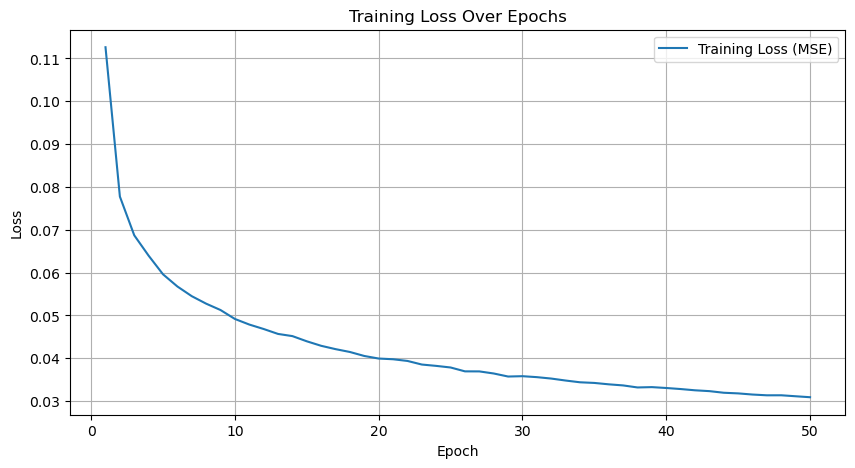

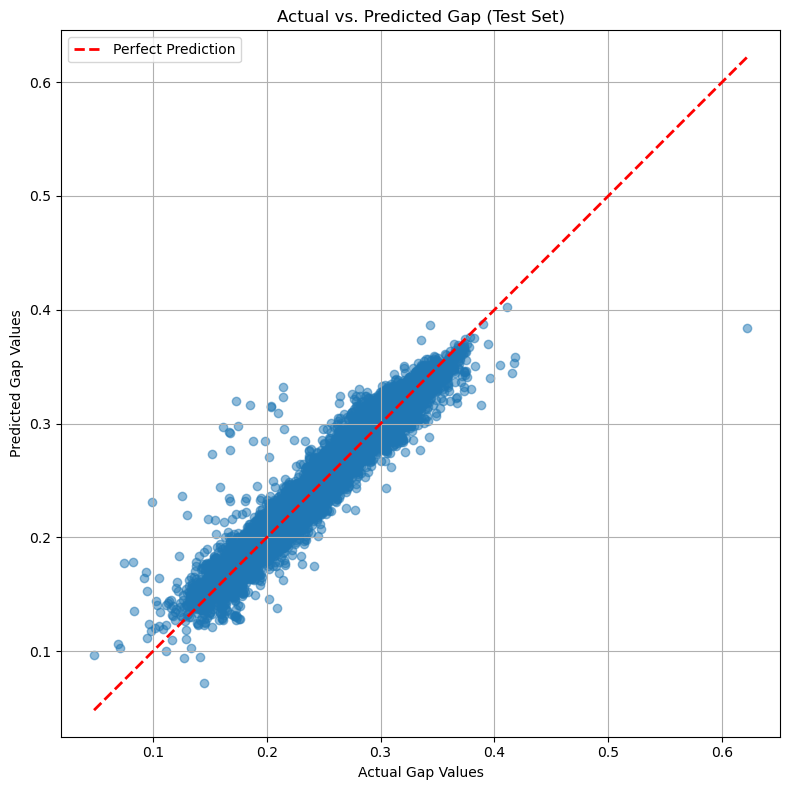

In [21]:
# --- 7. Optional: Plotting ---
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Predictions vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test_numpy, predictions, alpha=0.5)
# Add a line for perfect correlation
min_val = min(y_test_numpy.min(), predictions.min())
max_val = max(y_test_numpy.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Gap Values')
plt.ylabel('Predicted Gap Values')
plt.title('Actual vs. Predicted Gap (Test Set)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Make axes equal to better visualize correlation
plt.tight_layout()
plt.show()

Guardar

In [22]:
# --- 8. Optional: Save the Model ---
print("\nSaving model...")
torch.save(model.state_dict(), 'gap_predictor_model.pth')
print("Model saved to gap_predictor_model.pth")

# To load later:
model_loaded = GapPredictorMLP(EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, OUTPUT_DIM)
model_loaded.load_state_dict(torch.load('gap_predictor_model.pth'))
model_loaded.to(device)
model_loaded.eval()
# Don't forget to also save/load the scalers (scaler_x, scaler_y) if you plan to use the model on new, raw data!
import joblib
joblib.dump(scaler_x, 'scaler_x.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


Saving model...
Model saved to gap_predictor_model.pth


C:\Users\locua\AppData\Local\Temp\ipykernel_10952\2459626401.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load('gap_predictor_model

['scaler_y.pkl']